<a href="https://colab.research.google.com/github/blazyy/Coursera_Capstone/blob/master/The_Battle_of_Neighborhoods_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np 
import random
from tqdm import tqdm_notebook
import folium 
from geopy.geocoders import Nominatim
import urllib.request
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


#from IPython.display import Image 
#from IPython.core.display import HTML 
#from pandas.io.json import json_normalize

# The Battle of Neighborhoods

This notebook is part 1 of the submissions for the final capstone project in the IBM Data Science Professional Certificate course on Coursera.

## Preamble

Mr. Nolan is going to be moving in to the city of Chennai, located at the edge part of the Indian subcontinent. He needs to find suitable housing. However, he frets. He doesn't worry about the locality one bit; except the fulfillment of one condition: there needs to be a lot of restaurants/food stalls nearby. You see, Mr. Nolan is a foodie. Not a day goes by where he does not make or savour a new dish. He has come to me for help, asking me to analyze the different areas in the city of Chennai and find which neighborhoods would be the best for a foodie like him to move in to. 

Me, being the perfect philanthropist as I am, have decided to help Mr. Nolan using a bit of data and a bit of science. 

Jokes aside, here's how I plan to do it. 



## Introduction

The aim here is to find neighborhoods with a high frequency of restaurants/food stalls/cafes. Firstly, the number of neighborhoods and their respective coordinates need to be retrieved, so that Foursquare can find nearby venues. Using this data, Foursquare should search for nearby venues and get their categories. 

These venues are then clustered using k-means. The cluster in which eateries are of the highest frequency will be the set of neighborhoods we are looking for. All of these neighborhoods are suitable for Mr.Nolan to move in.

This problem can also be easily extended to fit other requests, such as finding the neighborhoods with low real estate prices, neighborhoods with a wide variety of grocery shops, neighborhoods closes to public transport systems etc. 

The target audience here is people who are moving to a new city and require some knowledge about the neighborhoods beforehand so that they can decide the place they want to live in. 

## Data

### Wikipedia Scraper

Since available data for Chennai city was sparse, I've manually scraped the list of neighborhoods from [this](https://en.wikipedia.org/wiki/Areas_of_Chennai) Wikipedia page using bs4, and then grabbed all the hyperlinks. Using urllib, these links are visited individually and the coordinates and pincodes (neighborhoods identifiers) are scraped and put into a pandas dataframe.

In [0]:
url = 'https://en.wikipedia.org/wiki/Areas_of_Chennai'
page_unparsed = urllib.request.urlopen(url)
soup = BeautifulSoup(page_unparsed, 'html.parser')

In [0]:
wiki_rows = [] # each row in the wikipedia table
urls = []
names = []

wiki_table = soup.find_all("table", {"class": "wikitable"})
for row in wiki_table:
  wiki_rows.append(row.find_all('a', href=True))

# gets names and links of each neighborhood so that further scraping can be done
for i in range(len(wiki_rows[0])):
  urls.append('https://en.wikipedia.org' + wiki_rows[0][i]['href'])
  names.append(wiki_rows[0][i].text)

In [128]:
# getting data from each neighborhood

latitudes = []
longitudes = []
pincodes = []

for url in tqdm_notebook(urls, total = len(urls), unit = 'url'):
  try: # because some links are broken
    page_unparsed = urllib.request.urlopen(url)
    soup = BeautifulSoup(page_unparsed, 'html.parser')
  except:
    continue

  coords = soup.find("span", {"class" : "geo-dec"})
  pincode = soup.find("div", {"class" : "postal-code"})

  if coords == None:  # because some pages do not have coordinates listed
    latitudes.append(np.nan)
    longitudes.append(np.nan)

  else:
    coords = coords.text.split()
    latitudes.append(float(coords[0].replace('N', '').replace('°', '')))
    longitudes.append(float(coords[1].replace('E', '').replace('°', '')))

In [129]:
neighborhoods = pd.DataFrame(list(zip(names, latitudes, longitudes)), columns =['Name', 'Latitude', 'Longitude']) 
neighborhoods = neighborhoods[neighborhoods['Latitude'].notnull()]
neighborhoods = neighborhoods[neighborhoods['Longitude'].notnull()]
neighborhoods.head()

,Name,Latitude,Longitude
0,Adambakkam,12.9900,80.2000
1,Adyar,13.0063,80.2574
2,Alandur,13.0030,80.2040
3,Alapakkam,13.0490,80.1673
4,Alwarpet,13.0339,80.2486


### Foursquare

Using Foursquare, individual neighboords are searched to find nearby venues and their categories withing a 500m radius of a randomnly chosen neighborhood, Choolaimedu.

In [0]:
CLIENT_ID = 'BEYJXL240KTU54SBM4YR1FGO2LSOQ5LVFBRAYFW5YNP4YFI0' # your Foursquare ID
CLIENT_SECRET = 'XOEBQ2HUD5KVGZVLD1ETXN45MF4NQN1XBAJ0FNN4R1VZA5D0' # your Foursquare Secret
VERSION = '20190130'

In [0]:
neighborhood_latitude = neighborhoods[neighborhoods['Name'] == 'Choolaimedu']['Latitude']
neighborhood_longitude = neighborhoods[neighborhoods['Name'] == 'Choolaimedu']['Longitude']

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID[::-1], 
    CLIENT_SECRET[::-1], 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [0]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [0]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in tqdm_notebook(zip(names, latitudes, longitudes), total = neighborhoods.shape[0], unit = 'neighborhoods'):
        # print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID[::-1], 
            CLIENT_SECRET[::-1], 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [134]:
chennai_venues = getNearbyVenues(names = neighborhoods['Name'],
                                   latitudes = neighborhoods['Latitude'],
                                   longitudes = neighborhoods['Longitude'])
chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.9900,80.2000,Pizza Republic,4bf58dd8d48988d1ca941735,12.990987,80.198613,Pizza Place
1,Adambakkam,12.9900,80.2000,Loiee,4bf58dd8d48988d16a941735,12.992197,80.199000,Bakery
2,Adambakkam,12.9900,80.2000,Thalapakattu Hotel,4bf58dd8d48988d142941735,12.991979,80.198937,Asian Restaurant
3,Adambakkam,12.9900,80.2000,The Great Kabab Factory,5283c7b4e4b094cb91ec88d7,12.993796,80.201702,Kebab Restaurant
4,Adyar,13.0063,80.2574,Bombay Brassiere,54135bf5e4b08f3d2429dfdd,13.006961,80.256419,North Indian Restaurant


# Methodology

One hot encoding.

In [135]:
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood'] 
fixed_columns = [chennai_onehot.columns[-1]] + list(chennai_onehot.columns[:-1])
chennai_onehot = chennai_onehot[fixed_columns]
chennai_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Camera Store,Chettinad Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Concert Hall,...,Park,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Platform,Playground,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Restaurant,Road,Rock Club,Russian Restaurant,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [136]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_grouped

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Camera Store,Chettinad Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Concert Hall,...,Park,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Platform,Playground,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Restaurant,Road,Rock Club,Russian Restaurant,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.0,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.250000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0,0.000000,0.032258,0.0,0.0,0.0,0.0,0.0,0.032258,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.000000,0.0,0.000000,0.032258,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.064516,0.000000
2,Alandur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Alapakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,Alwarpet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.037037,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Vadapalani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000

Getting the most frequent venues in each neighborhood.

In [137]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Pizza Place,Bakery,Kebab Restaurant,Asian Restaurant,Women's Store,Electronics Store,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market
1,Adyar,Indian Restaurant,North Indian Restaurant,Vegetarian / Vegan Restaurant,Electronics Store,Juice Bar,Coffee Shop,Dessert Shop,Movie Theater,Café,Fast Food Restaurant
2,Alandur,Hotel,Fish Market,South Indian Restaurant,Movie Theater,Donut Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Diner
3,Alapakkam,Indian Restaurant,Fast Food Restaurant,Women's Store,Donut Shop,Flea Market,Fishing Store,Fish Market,Farmers Market,Farm,Electronics Store
4,Alwarpet,Indian Restaurant,Lounge,Hotel,Japanese Restaurant,Restaurant,Thai Restaurant,Italian Restaurant,South Indian Restaurant,Pizza Place,Burger Joint


In [138]:
# set number of clusters
kclusters = 4

chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chennai_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

chennai_merged.head() # check the last columns!

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.9900,80.2000,1.0,Pizza Place,Bakery,Kebab Restaurant,Asian Restaurant,Women's Store,Electronics Store,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market
1,Adyar,13.0063,80.2574,0.0,Indian Restaurant,North Indian Restaurant,Vegetarian / Vegan Restaurant,Electronics Store,Juice Bar,Coffee Shop,Dessert Shop,Movie Theater,Café,Fast Food Restaurant
2,Alandur,13.0030,80.2040,1.0,Hotel,Fish Market,South Indian Restaurant,Movie Theater,Donut Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Diner
3,Alapakkam,13.0490,80.1673,0.0,Indian Restaurant,Fast Food Restaurant,Women's Store,Donut Shop,Flea Market,Fishing Store,Fish Market,Farmers Market,Farm,Electronics Store
4,Alwarpet,13.0339,80.2486,0.0,Indian Restaurant,Lounge,Hotel,Japanese Restaurant,Restaurant,Thai Restaurant,Italian Restaurant,South Indian Restaurant,Pizza Place,Burger Joint


In [139]:
chennai_merged = chennai_merged[chennai_merged['Cluster Labels'].notnull()]

# create map
map_clusters = folium.Map(location=[13.067439, 80.237617], zoom_start=11)

# set color scheme for the clusters
'''
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.hsv(np.linspace(0, 1, len(ys)))
hsv = [colors.rgb2hex(i) for i in colors_array]
'''

colors = ["#ff0000", "#3d84ad", "#000000", "#ffff00"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Name'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True,
        fill_color=colors[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

In [140]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Indian Restaurant    26
Bus Station           2
Clothing Store        2
Café                  1
Boutique              1
Name: 1st Most Common Venue, dtype: int64

In [141]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Ice Cream Shop                   9
Fast Food Restaurant             5
Vegetarian / Vegan Restaurant    5
Pizza Place                      5
Coffee Shop                      4
Name: 1st Most Common Venue, dtype: int64

In [142]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Kolathur,Pharmacy,Flower Shop,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Donut Shop,Diner
60,Manali,Pharmacy,Market,Motorcycle Shop,Electronics Store,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Donut Shop
64,Mangadu,Pharmacy,Spa,Donut Shop,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Diner
88,Otteri,Pharmacy,Flower Shop,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Donut Shop,Diner
93,Pallikaranai,Pharmacy,Light Rail Station,Donut Shop,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Diner
107,Poonamallee,Pharmacy,Flower Shop,Fishing Store,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Donut Shop,Diner


In [143]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Train Station    8
Bus Station      5
Church           1
Beach            1
Metro Station    1
Name: 1st Most Common Venue, dtype: int64

# Results

The following bar graph shows that Cluster 1 has the most number of restaurants. While a bar graph does not make enough sense here (because the clusters are clustered based on similarity factors other than distance between each other), it is useful to demonstrate the success of clustering. 

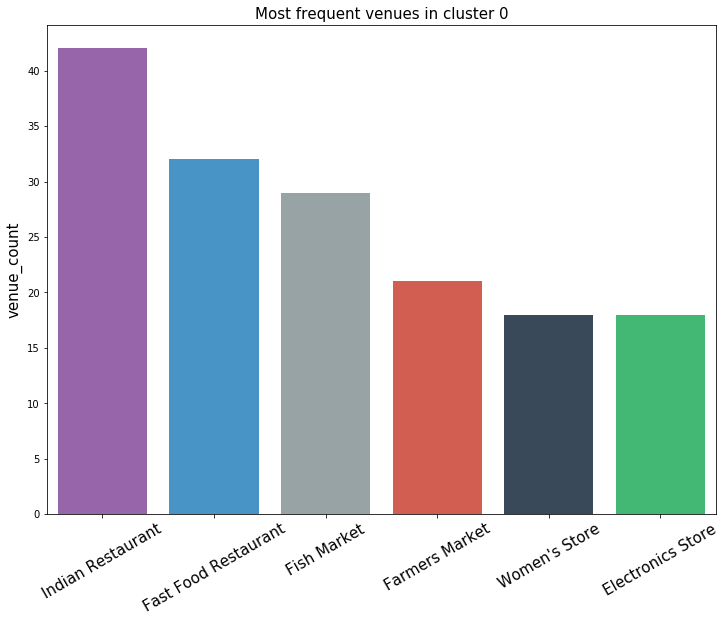

In [144]:
clus1 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 0].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x = clus1.index, y = clus1['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30,  fontsize = 15)
ax.yaxis.label.set_size(15)
plt.title('Most frequent venues in cluster 0', fontsize = 15)
plt.show()

The bar graphs for the rest of the clusters show that they do not have any significant similarities between each other.

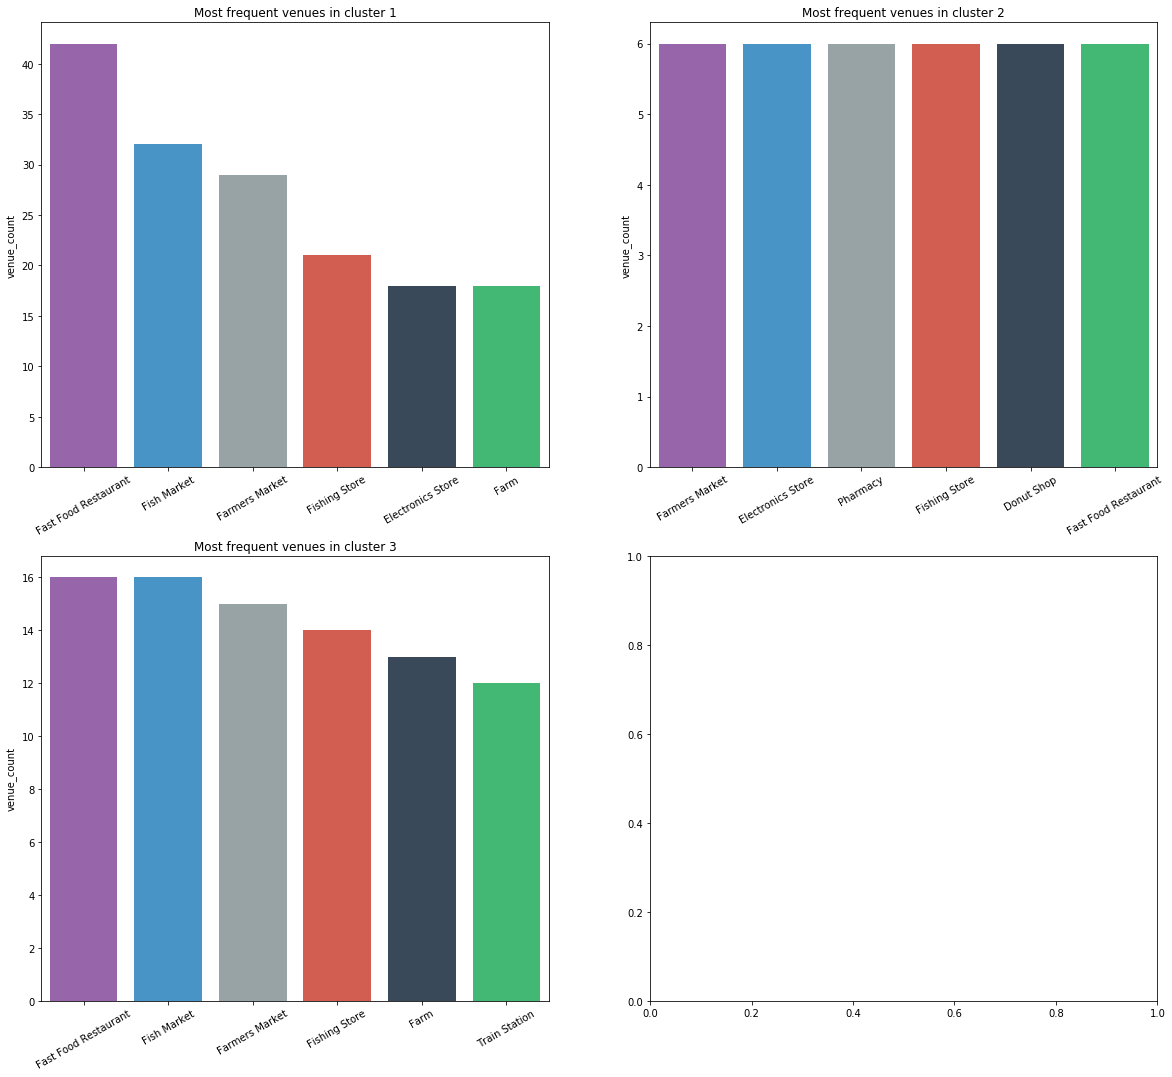

In [145]:
clus1 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 1].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])
clus2 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 2].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])
clus3 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 3].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(2,2, figsize = (20, 18))


plt.subplot(2, 2, 1)
ax = sns.barplot(x = clus1.index, y = clus0['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 1')

plt.subplot(2, 2, 2)
ax = sns.barplot(x = clus2.index, y = clus2['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 2')

plt.subplot(2, 2, 3)
ax = sns.barplot(x = clus3.index, y = clus3['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 3', )


plt.show()

# Discussion


In [146]:
chennai_venues['Venue Category'].value_counts()

Indian Restaurant                121
Fast Food Restaurant              32
Vegetarian / Vegan Restaurant     32
Train Station                     31
Bus Station                       29
                                ... 
Soccer Stadium                     1
Arts & Crafts Store                1
Antique Shop                       1
Pub                                1
Pier                               1
Name: Venue Category, Length: 147, dtype: int64

The sheer number of restaurants probably skew the results. There might be two reaons for this: 
* Foursquare data predominantly contains restaurant data.
* There are way too many restaurants in Chennai.

Chennai is not in any means a developed city. It contains numerous shops and stalls which simply will not be indexed or recorded by any location API like Foursquare, or even Google Maps. And multiple venues open each day, the updation of this data is also an issue. Due to these reasons, accurate analysis cannot be done. 


# Conclusion

Mr. Nolan would not have trouble finding food in the city of Chennai. For lesser travel times, he can choose any of the 58 neighborhoods in Cluster 1, however he'll find that most of them are Indian restaurants. Independent of travel distance, the cluster choice does not matter much as there are more restaurants than any other venue. There is simply not enough data to do an in-depth analysis. However, individually marking the venues which are food-related is also a possibility- something to do for the future. 

The efficacy of the project was impacted by the limited effectives of the Foursquare API for a place like Chennai. Using some other city would've probably yielded better results. The way the neighborhoods were suggested were due to Indian restaurants alone. More diversity from more food stalls could've been used, i.e. Donut Shops, Bakeries, Pizzerias, etc. 

Further analysis could've been done by using the rating of each venue however yet again ratings were not available for venues in Chennai. If ratings were available, individual restaurants in each locality could've been suggested. 